# The Software Bill of Materials (SBOM) Use Case

Following on from the data loading in `loader.ipynb`, this notebook demonstrates how to perform **Software Bill of Materials (SBOM) Analysis** using Cypher queries on the Neo4j graph database.

In this case, we are showing how a security team can achieve full **Code-to-Cloud traceability**. We move from identifying vulnerabilities in direct dependencies to uncovering "hidden" risks in **transitive dependencies**. Finally, we demonstrate how to map these software components to the running infrastructure to visualize the real-world exposure of your software supply chain.

### Key Capabilities Demonstrated:

* **Transitive Risk Detection**: Navigating the recursive `DEPENDENCY_OF` relationships to find vulnerabilities buried multiple layers deep in the stack.
* **Widespread Impact Analysis**: Instantly identifying every application across the enterprise that utilizes a specific vulnerable library or version.
* **Contextual Prioritization**: Determining which library patches are most urgent by correlating the SBOM with internet-facing infrastructure and "Crown Jewel" data.

In [11]:
from dotenv import load_dotenv
import os
from neo4j import GraphDatabase

load_dotenv()

# Connection details
URI = os.getenv("NEO4J_URI", "bolt://localhost:7687")
AUTH = (os.getenv("NEO4J_USER", "neo4j"), os.getenv("NEO4J_PASSWORD", "password"))
DB = os.getenv("NEO4J_DB", "nvd")

# A helper method to run Cypher queries
def run_cypher(query, parameters=None):
    driver = GraphDatabase.driver(URI, auth=AUTH)
    try:
        with driver.session(database=DB) as session:
            result = session.run(query, parameters or {})
            # .data() converts the stream into a list of dictionaries
            return result.data() 
    finally:
        driver.close()

## The Transitive Risk Discovery

This query covers the question "Which applications are at risk because they indirectly use the 'vulnerable-codec' library" ?

In [12]:
import pandas as pd

query = """
MATCH (v:CVE)-[:IDENTIFIED_IN]->(targetLib:Library)
MATCH path = (targetLib)-[:DEPENDENCY_OF*1..3]->(art:BuildArtifact)-[:RUNNING_AS]->(app:Application)
RETURN v.id AS CVE, 
       targetLib.name AS Vulnerable_Lib, 
       app.name AS Affected_App, 
       nodes(path) AS Dependency_Chain
"""

results = run_cypher(query)
# Print the results as an html table
df = pd.DataFrame(results)
df

,CVE,Vulnerable_Lib,Affected_App,Dependency_Chain
0,CVE-2021-44228,log4j-core,CustomerFacingAPI,"[{'name': 'log4j-core', 'language': 'Java', 'v..."
1,CVE-2021-45046,log4j-core,CustomerFacingAPI,"[{'name': 'log4j-core', 'language': 'Java', 'v..."
2,CVE-2021-44228,vulnerable-codec,CustomerFacingAPI,"[{'name': 'vulnerable-codec', 'language': 'Jav..."
3,CVE-2021-44228,log4j-core,LegacyParser,"[{'name': 'log4j-core', 'language': 'Java', 'v..."
4,CVE-2021-45046,log4j-core,LegacyParser,"[{'name': 'log4j-core', 'language': 'Java', 'v..."
5,CVE-2021-44228,vulnerable-codec,LegacyParser,"[{'name': 'vulnerable-codec', 'language': 'Jav..."
6,CVE-2025-24990,openssl,EdgeAuthenticator,"[{'name': 'openssl', 'language': 'C', 'version..."
7,CVE-2023-52163,openssl,EdgeAuthenticator,"[{'name': 'openssl', 'language': 'C', 'version..."


As in the case of the [APA](https://github.com/pedroleitao-neo4j/cyber-apa), we can visualise the results using NetworkX and Matplotlib to create a directed graph showing the dependency chains from the vulnerable library to the affected applications.

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

def run_cypher_list(query, parameters=None):
    driver = GraphDatabase.driver(URI, auth=AUTH)
    try:
        with driver.session(database=DB) as session:
            result = session.run(query, parameters or {})
            # Converting to a list consumes the stream but keeps native objects
            return list(result) 
    finally:
        driver.close()

def visualize_sbom_dependency_chain(query_results):
    if not query_results:
        print("No dependency chains found to visualize.")
        return

    # Initialize a Directed Graph
    G = nx.DiGraph()

    for record in query_results:
        path = record['path']
        
        # Add Nodes and Edges from the path
        for node in path.nodes:
            # Extract Label and Name for display
            node_label = list(node.labels)[0]
            node_name = node.get('name') or node.get('id')
            node_id = node.element_id
            
            # Store metadata for styling
            G.add_node(node_id, label=f"{node_label}\n{node_name}", type=node_label)
            
        for rel in path.relationships:
            # We use the relationship type (e.g., IDENTIFIED_IN, DEPENDENCY_OF)
            G.add_edge(rel.start_node.element_id, rel.end_node.element_id, label=rel.type)

    # Setup Layout and Styling
    plt.figure(figsize=(14, 8))
    # Multipartite or spring layout works well for showing lineage
    pos = nx.spring_layout(G, k=1.0, iterations=50)
    
    # Color Logic based on Node Type
    color_map = []
    for node_id in G.nodes():
        n_type = G.nodes[node_id].get('type')
        if n_type == 'CVE' or n_type == 'Vulnerability': 
            color_map.append('#ab149e') # Purple for risk
        elif n_type == 'Library': 
            color_map.append('#dbdf00') # Yellow for software components
        elif n_type == 'Application': 
            color_map.append('#ff7f0e') # Orange for business apps
        else: 
            color_map.append('#a6cee3') # Light blue for others

    # Draw the Graph
    nx.draw(G, pos, with_labels=True, 
            labels=nx.get_node_attributes(G, 'label'),
            node_color=color_map, 
            node_size=3500, 
            font_size=8, 
            font_weight='bold',
            arrows=True,
            arrowsize=20,
            edge_color='gray')
    
    # Draw edge labels (Relationship types)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

    plt.title("SBOM Transitive Risk: Code Lineage & Dependency Chain")
    plt.show()

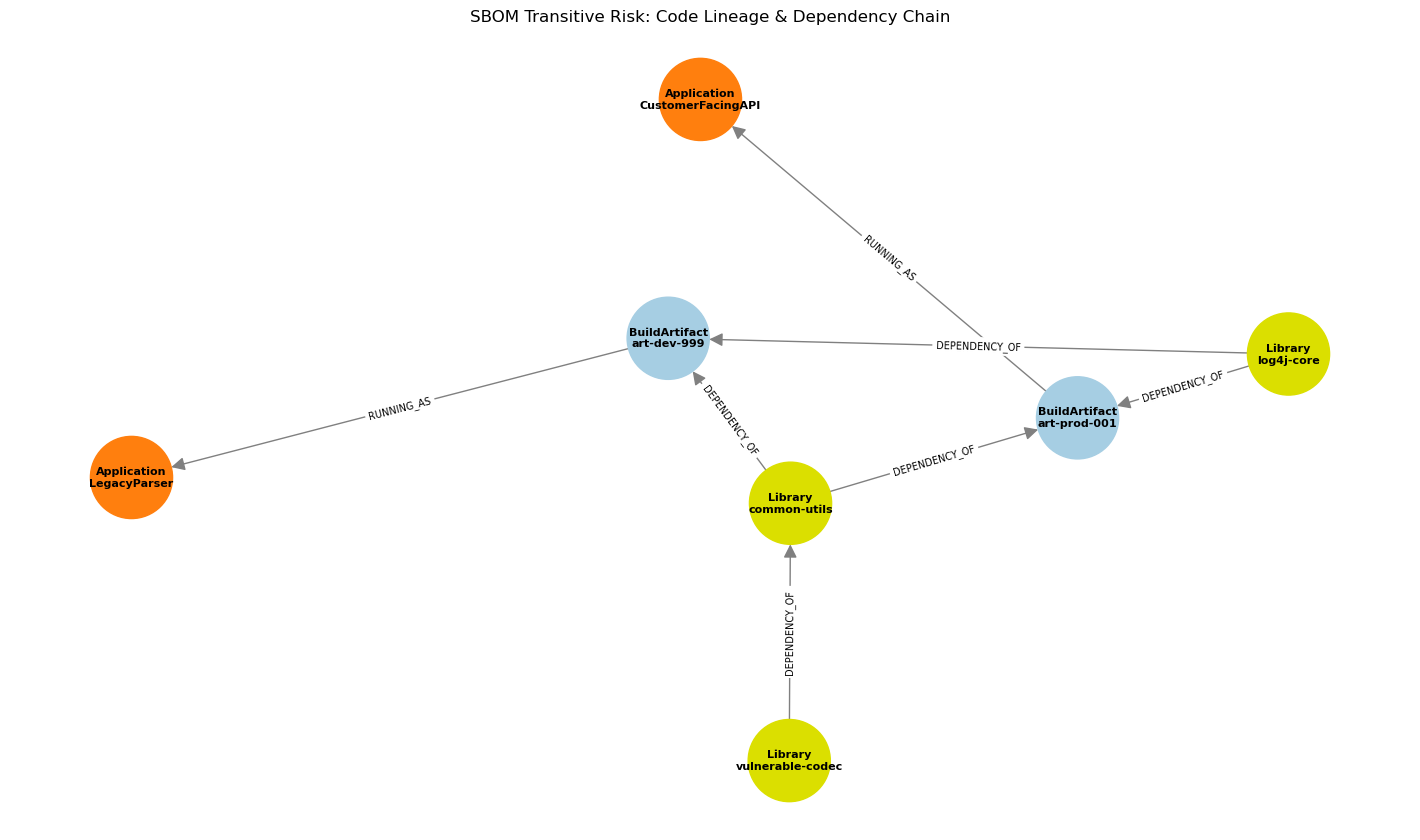

In [14]:
# This query finds the transitive path from a CVE to an Application
query = """
MATCH (v:CVE {id: 'CVE-2021-44228'})-[:IDENTIFIED_IN]->(lib:Library)
MATCH path = (lib)-[:DEPENDENCY_OF*1..3]->(art:BuildArtifact)-[:RUNNING_AS]->(app:Application)
RETURN path
"""
results = run_cypher_list(query)
visualize_sbom_dependency_chain(results)

## Reachability Analysis for SBOM

The final query demonstrates how to trace the path from a vulnerable library all the way to the running compute instances in the cloud, answer the question "Show me the full path from a poisoned library to the internet-facing compute instances running affected applications".

In [15]:
query = """
MATCH (v:CVE)-[:IDENTIFIED_IN]->(l:Library)
MATCH path = (l)-[:DEPENDENCY_OF*1..3]->(:BuildArtifact)-[:RUNNING_AS]->(app:Application)-[:HOSTED_ON]->(ins:ComputeInstance)
WHERE ins.public_ip IS NOT NULL
RETURN v.id AS CVE, app.name AS App, ins.name AS Server, ins.public_ip AS IP
"""

results = run_cypher(query)
df = pd.DataFrame(results)
df

,CVE,App,Server,IP
0,CVE-2021-44228,CustomerFacingAPI,api-gateway-01,34.201.1.5
1,CVE-2021-45046,CustomerFacingAPI,api-gateway-01,34.201.1.5
2,CVE-2021-44228,CustomerFacingAPI,api-gateway-01,34.201.1.5
3,CVE-2025-24990,EdgeAuthenticator,edge-auth-01,52.14.99.1
4,CVE-2023-52163,EdgeAuthenticator,edge-auth-01,52.14.99.1
